# CS-433 Machine Learning - Project 2
## Option A - LPBS lab (42) with Sahand Rahi
### Majandra Garcia 347470, Mattia Moro 395819, Louis Tschanz 315774

In [40]:
import os
import numpy as np
from helpers import *
from models import *   
from nan_imputation import impute_nan
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from load_data import load_lifespan, load_earlylifespan
from nan_imputation import *
from Preprocessing import *
from preprocessing_features import preprocess_dataset
from sklearn.preprocessing import StandardScaler
from evaluations import *

## 1. Lifespan prediction based on early behavior

At first, import repository root and load data for regression (from the two controls and the company drug).

In [41]:
repo_root = find_repo_root()
data_path = os.path.join(repo_root, 'Data/Lifespan')
fdict = load_lifespan(data_path)

### 1.1 Preprocessing ###

The preprocessing consists in :
- remove all Nan values;
- create initial class labels for both classification and regression;
- revise regression labels using death estimation function;
- perform data augmentation on worm coordinates;
- feature expansion, to get all summary features for lifespan time series;

In [42]:
cut_lifespan_dict = remove_nans(fdict) #remove nans
labels = create_classes(cut_lifespan_dict) #create array with 
revised_death_times = estimate_death_times(cut_lifespan_dict) #correct estimated death times

#now we can create the first official version of the regression and classification label vectors
y_reg = np.array(revised_death_times)
y_class = np.array(labels[:,0].astype(int))

#data augmentation, getting final label vectors and samples list, which is 2 times bigger than the original one
samples, y_reg_final, y_class_final = augment_worms(cut_lifespan_dict, y_reg, y_class)

#feature expansion from samples list
features = list(preprocess_dataset(samples)) #get the final features
X = pd.DataFrame(features[0:len(features)+1]) #create the features dataframe

Then, before performing any prediction task, we also have to:
- split between training and test sets for both tasks;
- normalize the dataframe with a standard scaler.

In [43]:
#do this for regression first
X_train, X_test, y_train, y_test = train_test_split(X, y_reg_final, test_size=0.2, random_state=42)
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

#and now for classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class_final, test_size=0.2, random_state=42)
stdsc.fit(X_train_c)
X_train_std_c = stdsc.transform(X_train_c)
X_test_std_c = stdsc.transform(X_test_c)

### 1.2 Linear Regression

We can finally run linear regression to predict worm lifespan! Note that the task is to predict how many frames the worm will live given early lifespan. As the first worm died after 42.000 frames, the early lifespan threshold was manually adjusted to 35k frames.

In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_std, y_train)
y_pred_lr = model.predict(X_test_std)

The model is then evaluated in this way:
- quantitatively with r-squared coefficient, MAE and RMSE;
- qualitatively, by plotting survival curves obtained with scikit-survival's Kaplain-Meier estimator ran on predicted and true lifespans.

In [45]:
quant_evaluation(y_test, y_pred_lr) #quantitative evaluation

Model Performances: 
Root Mean Squared Error (RMSE): 3011.8788528440964
Mean Absolute Error (MAE): 2216.3953441556273
R-squared: 0.8551119153440565


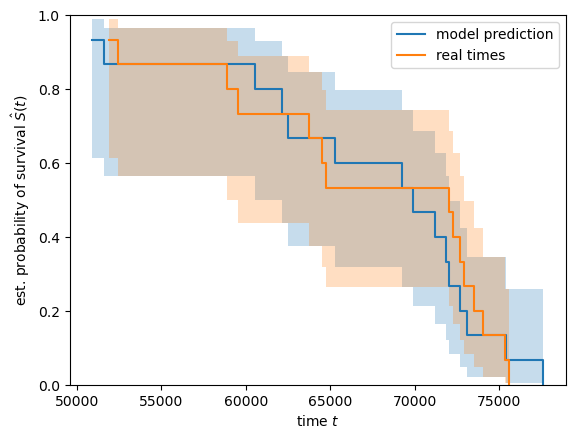

In [46]:
double_curve(y_test, y_pred_lr) #qualitative evaluation

---

## 2. Assessment of personality of worms based on early behavior 

### 2.1 Load data

In [47]:
import personality as prs
import load_data as ld
import helpers as hp
import nan_imputation as ni
import Preprocessing as pp
import isdead as id
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [48]:
# Load data
repo_root = hp.find_repo_root()
optogenetics_path = os.path.join(repo_root, 'Data', 'Optogenetics')
opto_data = ld.load_optogenetics(optogenetics_path)

### 2.2 Preprocessing the data

NaN imputation

In [49]:
# Rows to check for missing values (2:4 in zero-based indexing) -> Rows 2 and 3, not row 4
rows_to_check = slice(2, 4)

# Apply cut_array to each worm in the dataset
cut_nan_dict = {name: ni.cut_array(array, rows_to_check) for name, array in opto_data.items()}

### 2.3 Clustering

Feature matrix

In [50]:
worm_dataframes = []

# Iterate over each worm in cut_nan_dict
for worm_name, worm_array in cut_nan_dict.items():
    # Convert the NumPy array to a pandas DataFrame
    worm_df = pd.DataFrame(
        worm_array.T, 
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse', 'Category']  # Add column names
    )
    worm_dataframes.append(worm_df)

# Check if conversion worked
print(f"Converted {len(worm_dataframes)} worms into DataFrames.")

# Use create_feature_matrix to generate features
feature_matrix = prs.create_feature_matrix(worm_dataframes, percentile=50)

# Display the feature matrix
print("Feature Matrix:")
print(feature_matrix.head())

Converted 42 worms into DataFrames.
Feature Matrix:
  worm_name  average_speed  variance_speed  threshold  movement_frequency  \
0    Worm 1       4.368967     1138.798265   1.066618           50.000000   
1    Worm 2       1.623409      363.418113   0.749258           49.999349   
2    Worm 3       2.886690      256.786384   1.011278           50.000000   
3    Worm 4       2.356340      123.662434   1.136713           49.999637   
4    Worm 5       2.050638       38.852848   1.098204           49.999625   

   active_time_ratio  total_distance  area_explored  
0           0.500000   209348.417733  297341.655305  
1           0.499993    88413.638818  348324.705543  
2           0.500000   355714.494935  268988.276081  
3           0.499996   276649.186244  183695.000864  
4           0.499996   142184.069605  210705.781073  


#### 2.3.1 Hierarchical clustering to find the number of clusters

Dendrogram saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\hierarchical_dendrogram.png


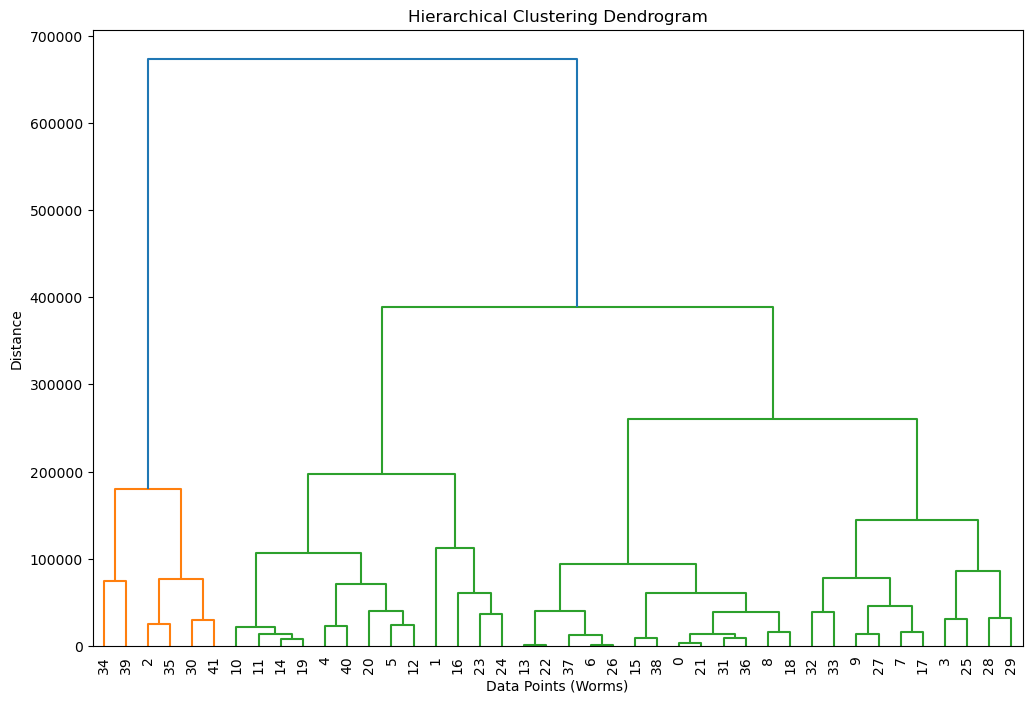

In [51]:
# Prepare input for clustering -> drop non-numeric columns like 'worm_name' or any other metadata
feature_matrix_copy = feature_matrix.copy()
clustering_input = feature_matrix_copy.drop(columns=['worm_name'])

dendrogram_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'hierarchical_dendrogram.png')
os.makedirs(os.path.dirname(dendrogram_path), exist_ok=True)

prs.perform_hierarchical_clustering(
    feature_matrix=clustering_input,  # Pass only numeric data
    method='ward',
    output_file=dendrogram_path
)

print(f"Dendrogram saved to: {dendrogram_path}")

> With this plot, we can determine the optimal number of clusters by observing the distances on the y-axis. We can see 2 main colors arriving at the end of the "tree", orange and green.
>
> There is a large gap between the branches merging near 700'000 and the next set of branches around 400'000. If we "cut" horizontally at 400'000, we would have 2 clusters.
>
> Cutting the dendrogram around 200'000 creates 3 clusters, and cutting below 100'000 results in more clusters (5-6).

We decided to try with 2, as it gave the best results (3 was also tested)

#### 2.3.2 K-means Clustering with PCA plot

In [52]:
num_clusters = 2

# Define the personality map for 2 clusters (can be adjusted based on interpretations)
personality_map = {
    0: 'Cluster 0',  # Adjust labels after analyzing clustering results
    1: 'Cluster 1'
}

# Perform K-Means clustering
clustered_feature_matrix = prs.perform_kmeans_clustering(
    feature_matrix=clustering_input.copy(), 
    num_clusters=num_clusters, 
    personality_map=personality_map
)

# Preserve worm names for reference
worm_names = feature_matrix['worm_name']
# Reattach worm names to the clustered feature matrix
clustered_feature_matrix['worm_name'] = worm_names.values

c:\Users\msgar\miniconda3\envs\env_ML\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


PCA plot for visualization

PCA plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\pca_clusters.png


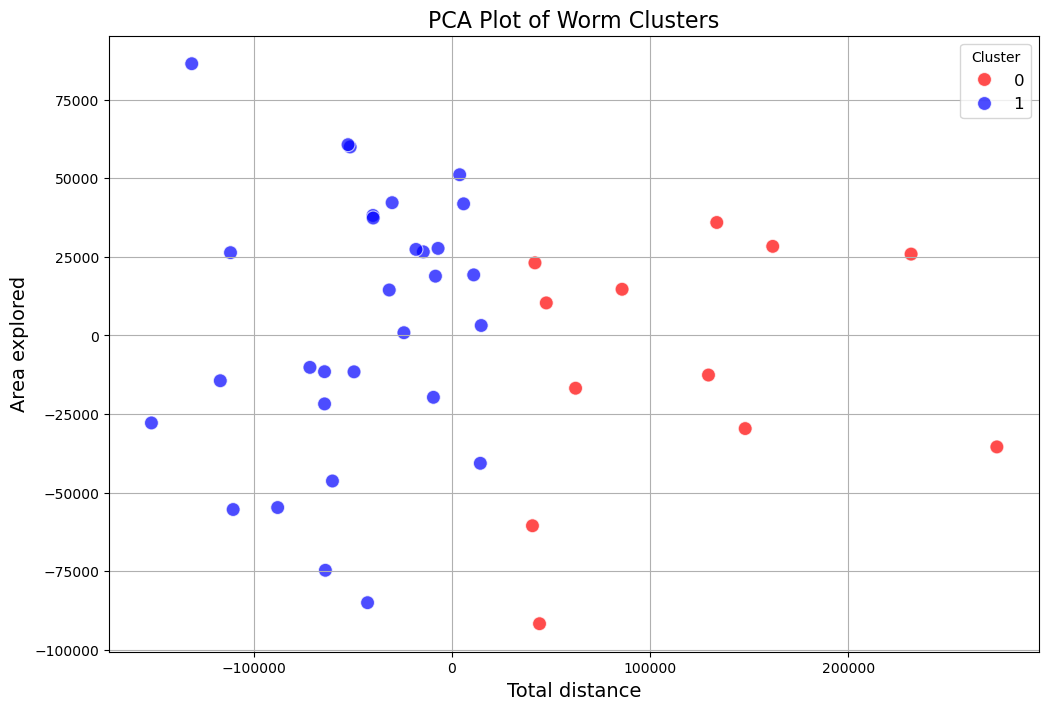

In [53]:
from sklearn.decomposition import PCA
import seaborn as sns

# Prepare the data for PCA
clustered_feature_matrix_PCA = clustered_feature_matrix.copy()
numeric_features = clustered_feature_matrix_PCA.drop(columns=['worm_name', 'Cluster', 'Personality'])  # Drop non-numeric columns
cluster_labels = clustered_feature_matrix_PCA['Cluster']  # Save the cluster labels

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numeric_features)

# Add PCA results to the clustered feature matrix
clustered_feature_matrix_PCA['PCA1'] = pca_result[:, 0]
clustered_feature_matrix_PCA['PCA2'] = pca_result[:, 1]

# Plot the PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',  # Color by cluster
    data=clustered_feature_matrix_PCA,
    palette={0: 'red', 1: 'blue'},
    s=100,
    alpha=0.7
)
plt.title('PCA Plot of Worm Clusters', fontsize=16)
plt.xlabel('Total distance', fontsize=14)
plt.ylabel('Area explored', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.grid(True)

# Save the PCA plot
pca_plot_path = os.path.join(repo_root, 'Data', 'Plots', 'personality', 'pca_clusters.png')
plt.savefig(pca_plot_path)
print(f"PCA plot saved to: {pca_plot_path}")

plt.show()

Display the PCA loadings (weights of each feature for each component)

In [54]:
pca_loadings = pd.DataFrame(
    pca.components_,
    columns=numeric_features.columns,
    index=['PCA1', 'PCA2']
)

print("PCA Loadings:")
print(pca_loadings)

PCA Loadings:
      average_speed  variance_speed     threshold  movement_frequency  \
PCA1   7.030044e-06        0.001751  5.798522e-07        4.307705e-10   
PCA2  -4.451725e-07        0.000280  3.037353e-07        7.879214e-10   

      active_time_ratio  total_distance  area_explored  
PCA1       4.307705e-12        0.997205       0.074699  
PCA2       7.879214e-12       -0.074700       0.997206  


> From this, PCA1 (x-axis) is more influenced by total distance (0.997205), and PCA2 (y-axis) is more influenced by area explored (0.997206). We changed the name of the axis in accordance.

 >

### 2.4 Classification

#### 2.4.1 Random Forest Classification - with augmented data

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

clustered_feature_matrix_aug = clustered_feature_matrix.copy()

# Prepare the original feature matrix and labels
X_original = clustered_feature_matrix_aug.drop(columns=['worm_name', 'Cluster', 'Personality'])  # Features
y_original = clustered_feature_matrix_aug['Cluster']  # Labels

# Create cut_lifespan_dict to emulate the structure needed for augmentation
cut_lifespan_dict = {
    f"worm_{i}": np.vstack([
        np.zeros((len(X_original.columns), len(X_original.columns))),  # Placeholder for additional features
        X_original.iloc[i].values.reshape(-1, 1).repeat(len(X_original.columns), axis=1)
    ]) for i in range(len(X_original))
}

# Perform data augmentation
augmented_samples, y_reg_augmented, y_class_augmented = pp.augment_worms(
    cut_lifespan_dict=cut_lifespan_dict,
    y_reg=np.zeros(len(y_original)),  # Dummy regression labels
    y_class=y_original.values
)

# Align augmented samples to match original feature columns
def align_features(aug_samples, original_features):
    aligned_samples = []
    for sample in aug_samples:
        full_sample = np.zeros((sample.shape[0], len(original_features)))
        full_sample[:, :sample.shape[1]] = sample
        aligned_samples.append(full_sample)
    return aligned_samples

aligned_samples = align_features(augmented_samples, X_original.columns)

# Flatten augmented samples for DataFrame creation
aligned_samples_flat = np.vstack(aligned_samples)

# Dynamically calculate the number of augmentations per sample
num_original_samples = len(X_original)
num_augmented_samples = len(aligned_samples_flat)
num_augmentations_per_sample = num_augmented_samples // num_original_samples  # Calculate augmentations per sample

# Repeat labels dynamically to match augmented data
repeated_labels = np.repeat(y_original.values, num_augmentations_per_sample)

# Ensure the length of repeated labels matches the augmented feature matrix
if len(repeated_labels) != num_augmented_samples:
    raise ValueError(
        f"Mismatch between augmented data and labels. "
        f"Augmented samples: {num_augmented_samples}, Labels: {len(repeated_labels)}"
    )

# Convert augmented samples into a DataFrame
augmented_feature_matrix = pd.DataFrame(
    aligned_samples_flat, 
    columns=X_original.columns
)
augmented_feature_matrix['Cluster'] = repeated_labels  # Add back the labels

# Split into training and testing sets
X_augmented = augmented_feature_matrix.drop(columns=['Cluster'])
y_augmented = augmented_feature_matrix['Cluster']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the classifier
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_augmented.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importances)

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.03      0.05        33
           1       0.71      0.94      0.81        85

    accuracy                           0.69       118
   macro avg       0.44      0.49      0.43       118
weighted avg       0.56      0.69      0.60       118

Accuracy: 0.69

Feature Importance:
              Feature  Importance
2           threshold    0.508922
1      variance_speed    0.491078
0       average_speed    0.000000
3  movement_frequency    0.000000
4   active_time_ratio    0.000000
5      total_distance    0.000000
6       area_explored    0.000000


C:\Users\msgar\AppData\Local\Temp\ipykernel_26596\1056620077.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Feature importance plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\feature_importance_random_forest.png


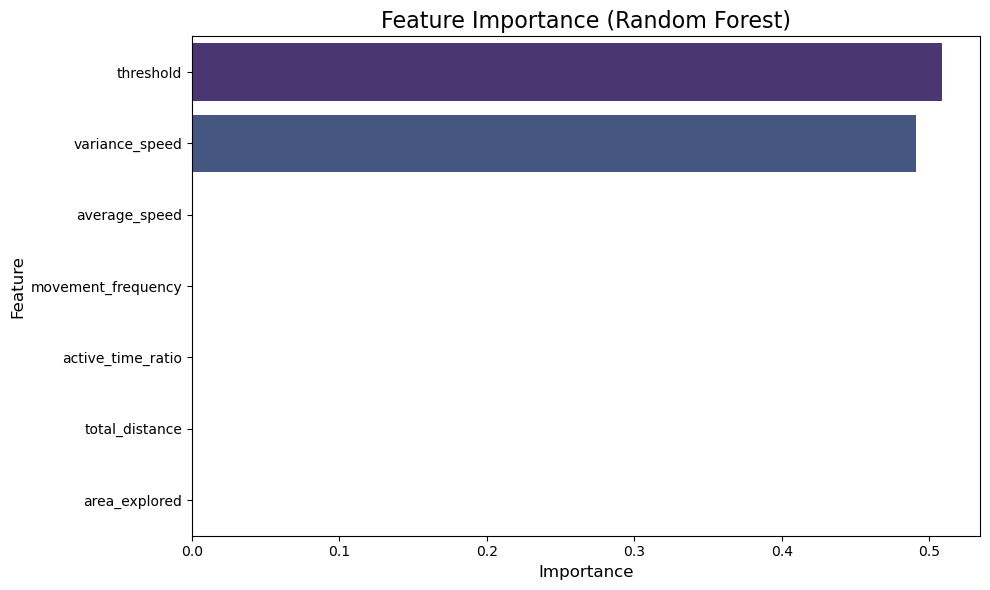

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the feature importances as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances,
    palette='viridis'
)
plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()

# Save the plot
output_dir = os.path.join(repo_root, 'Data', 'Plots', 'personality')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'feature_importance_random_forest.png')
plt.savefig(output_path)

print(f"Feature importance plot saved to: {output_path}")
plt.show()


#### 2.4.2 Logistic regression (no augmentation) and Cross validation

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9

Test Set Accuracy: 1.0000

10-Fold Cross-Validation Scores: [1.   1.   1.   1.   1.   1.   1.   0.75 1.   1.  ]
Mean Accuracy: 0.9750
Standard Deviation: 0.0750

Feature Coefficients (Logistic Regression):
              Feature  Coefficient
5      total_distance    -0.001695
2           threshold    -0.000537
3  movement_frequency     0.000479
6       area_explored    -0.000256
1      variance_speed     0.000115
0       average_speed    -0.000019
4   active_time_ratio     0.000005


C:\Users\msgar\AppData\Local\Temp\ipykernel_26596\1177155656.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Feature importance plot saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\personality\feature_importance_logistic_reg.png


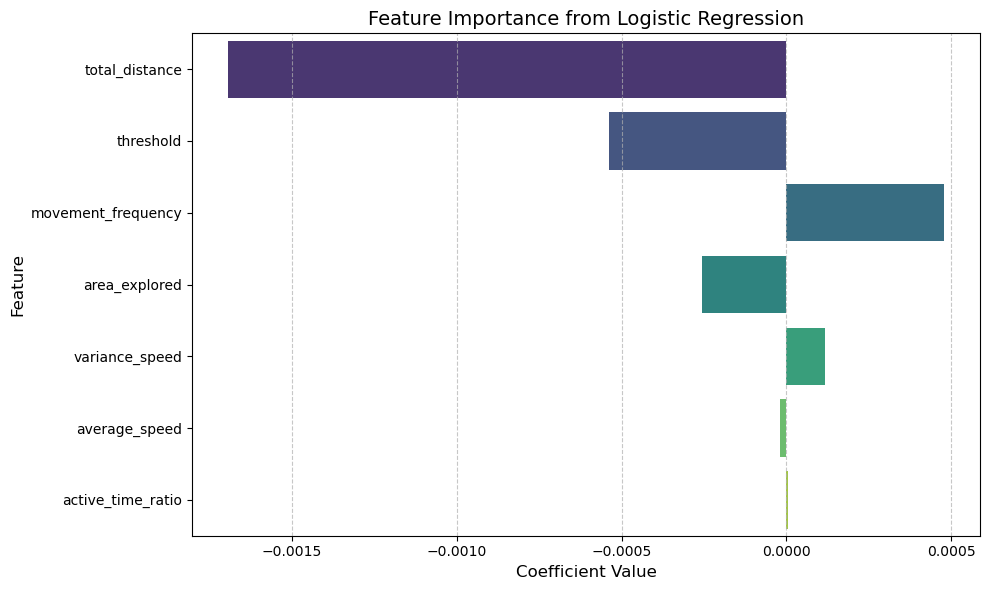

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

# Logistic Regression and Cross-Validation on Original Feature Matrix
X = clustered_feature_matrix.drop(columns=['worm_name', 'Cluster', 'Personality'])
y = clustered_feature_matrix['Cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model using OneVsRestClassifier for binary classification
logistic_model = OneVsRestClassifier(LogisticRegression(random_state=42, max_iter=500))
logistic_model.fit(X_train, y_train)

# Predict on test set
y_pred = logistic_model.predict(X_test)

# Evaluate the classifier
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Perform 10-fold cross-validation
cv_scores = cross_val_score(logistic_model, X, y, cv=10, scoring='accuracy')
print(f"\n10-Fold Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Feature Importance (Coefficients)
coefficients = logistic_model.estimators_[0].coef_[0]  # Extract coefficients from one of the estimators
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

print("\nFeature Coefficients (Logistic Regression):")
print(feature_importance)

# Visualization of Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance,
    x='Coefficient',
    y='Feature',
    palette="viridis"
)
plt.title("Feature Importance from Logistic Regression", fontsize=14)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
output_dir = os.path.join(repo_root, 'Data', 'Plots', 'personality')
os.makedirs(output_dir, exist_ok=True)
feature_importance_path = os.path.join(output_dir, 'feature_importance_logistic_reg.png')
plt.savefig(feature_importance_path)
print(f"Feature importance plot saved to: {feature_importance_path}")

plt.show()

---

## 3. Observing behavior before and during a light pulse

### 3.1 Create plots that compare speed and changed pixels before and during light pulse

In [58]:
import load_data as ld
import helpers as hp
import nan_imputation as ni
import light_pusle as lp
import os
import pandas as pd
import numpy as np
import importlib

In [59]:
# Take back cut_nan_dict
for worm_name, worm_array in cut_nan_dict.items():    
    # Convert NumPy array to DataFrame
    worm_df = pd.DataFrame(
        worm_array.T, 
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light_Pulse', 'Category']
    )
    # Detect light pulses
    light_pulses = lp.detect_light_pulses(worm_df, pulse_column='Light_Pulse', pulse_length_min=8, pulse_length_max=15)
    if light_pulses:
        
        # Compare behavior before and during light pulses
        behavior_comparisons = lp.compare_behavior_before_during(worm_df, light_pulses)
        
        # Visualize changes (Speed and Changed Pixels)
        for feature in ['Speed', 'Changed Pixels']:
            lp.plot_behavior_changes(behavior_comparisons, feature, worm_name)
    else:
        print(f"No valid light pulses detected for {worm_name}.")

### 3.2 Train a classifier
#### 3.2.1 Compare behavior before and during light pulse, train classifier without light pulse information, and detect light pulses using behavior only

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize list to store all behavior comparisons for all worms
all_comparisons = []

# Process each worm in `cut_nan_dict`
for worm_name, worm_array in cut_nan_dict.items():
    # Convert NumPy array to DataFrame
    worm_df = pd.DataFrame(
        worm_array.T, 
        columns=['Frame', 'Speed', 'X', 'Y', 'Changed Pixels', 'Light Pulse', 'Category']
    )
    # Detect light pulses
    light_pulses = lp.detect_light_pulses(worm_df, pulse_column='Light Pulse', pulse_length_min=8, pulse_length_max=15)
    if light_pulses:
        # Compare behavior before and during light pulses
        behavior_comparisons = lp.compare_behavior_before_during(worm_df, light_pulses)
        behavior_comparisons['Worm Type'] = worm_df['Category'].iloc[0]  # Add ATR+ or ATR- information
        behavior_comparisons['Worm Name'] = worm_name  # Add worm name
        all_comparisons.append(behavior_comparisons)

# Combine all behavior comparisons into a single DataFrame
comparison_df = pd.concat(all_comparisons, ignore_index=True)

# Assign labels: Reactive (ATR+) = 1, Non-Reactive (ATR-) = 0
comparison_df['Reactive'] = comparison_df['Worm Type'].apply(lambda x: 1 if x == 1 else 0)

# Select features and labels for the classifier
features = comparison_df[['Speed Before', 'Speed During', 'Changed Pixels Before', 'Changed Pixels During',
                          'Distance Before', 'Distance During']]
labels = comparison_df['Reactive']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)

# Save feature importances
repo_root = hp.find_repo_root()
output_path = os.path.join(repo_root, 'Data', 'Plots', 'light_pulses', 'feature_importances.csv')
feature_importances.to_csv(output_path, index=False)
print(f"Feature importances saved to: {output_path}")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.97      0.96      0.96       249

    accuracy                           0.97       549
   macro avg       0.97      0.97      0.97       549
weighted avg       0.97      0.97      0.97       549

Accuracy: 0.97

Feature Importances:
                 Feature  Importance
3  Changed Pixels During    0.416911
1           Speed During    0.324342
5        Distance During    0.079878
2  Changed Pixels Before    0.070371
4        Distance Before    0.054480
0           Speed Before    0.054018
Feature importances saved to: c:\Users\msgar\OneDrive\Documents\EPFL\Cours\MA1\Machine_Learning\ML_project2\ML-Project-2\Data\Plots\light_pulses\feature_importances.csv


#### 3.2.2 Boxplots of Speed and Changed pixels of reactive (ATR+) and non-reactive (ATR-) worms

C:\Users\msgar\AppData\Local\Temp\ipykernel_26596\3342684815.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


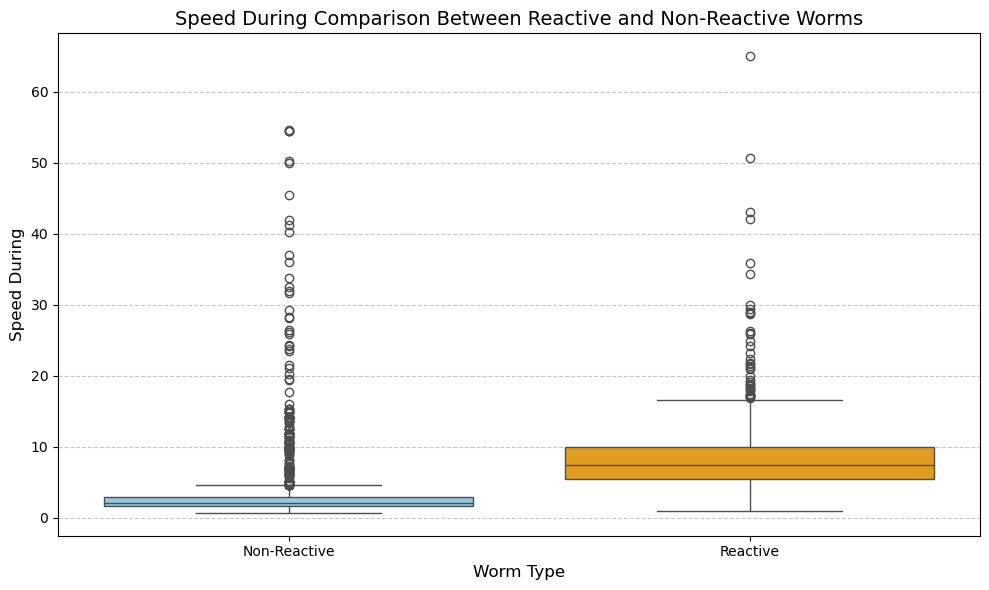

C:\Users\msgar\AppData\Local\Temp\ipykernel_26596\3342684815.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


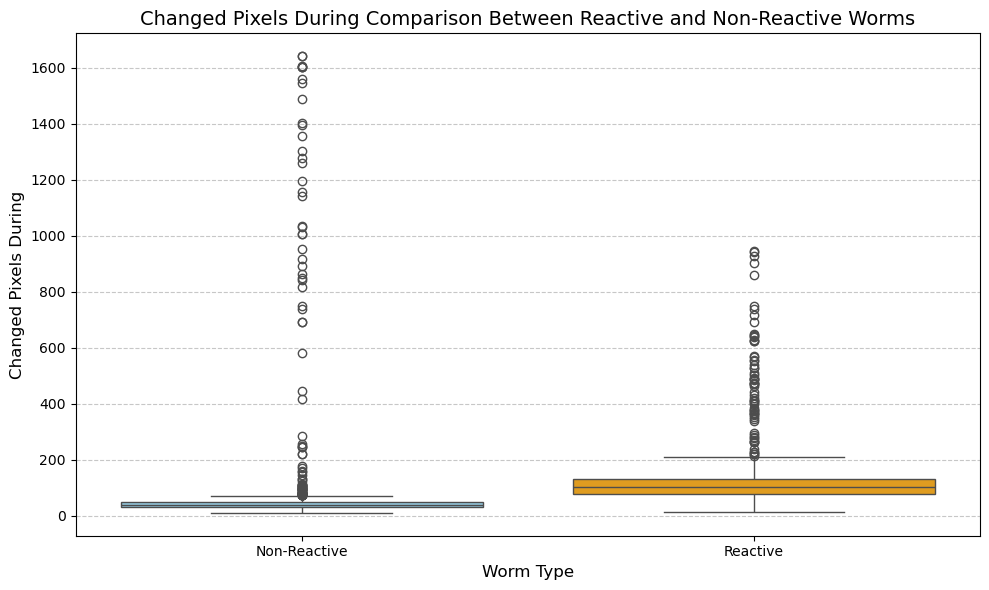

In [61]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Map worm type to descriptive labels
comparison_df['Worm Type'] = comparison_df['Worm Type'].map({0: 'Non-Reactive', 1: 'Reactive'})

# Define the features to visualize
features = ['Speed During', 'Changed Pixels During']

# Iterate through each feature to create boxplots
for feature in features:
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=comparison_df,
        x='Worm Type',
        y=feature,
        palette={"Non-Reactive": "skyblue", "Reactive": "orange"}  # Keys match string labels
    )
    plt.title(f"{feature} Comparison Between Reactive and Non-Reactive Worms", fontsize=14)
    plt.xlabel("Worm Type", fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the plot
    output_dir = os.path.join(repo_root, 'Data', 'Plots', 'light_pulses', 'Boxplots')
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{feature}_comparison_reactive_nonreactive.png")
    plt.savefig(output_path)

    # Close the plot to avoid overlap
    plt.show()
    #plt.close()

> All plots of the project are saved in ML-PROJECT-2/Data/Plots